In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm

# Visual
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Paths
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_3"
assert DATA_DIR.exists(), f"No se encontró {DATA_DIR}"
DATA_DIR

PosixPath('/Users/marvelo/Documents/ImperialCollege/capstone/initial_data/function_3')

Shape X: (15, 3), Shape y: (15,)
y stats: min=-0.3989  max=-0.0348  mean=-0.1072  std=0.0842
Week 1 added: x=[0.94995968 0.98491081 0.40447853], y=-0.04185694811542118
Week 2 added: x=[0.741774 0.823083 0.500825], y=-0.028695780761497047
Updated shapes: X=(17, 3), y=(17,)


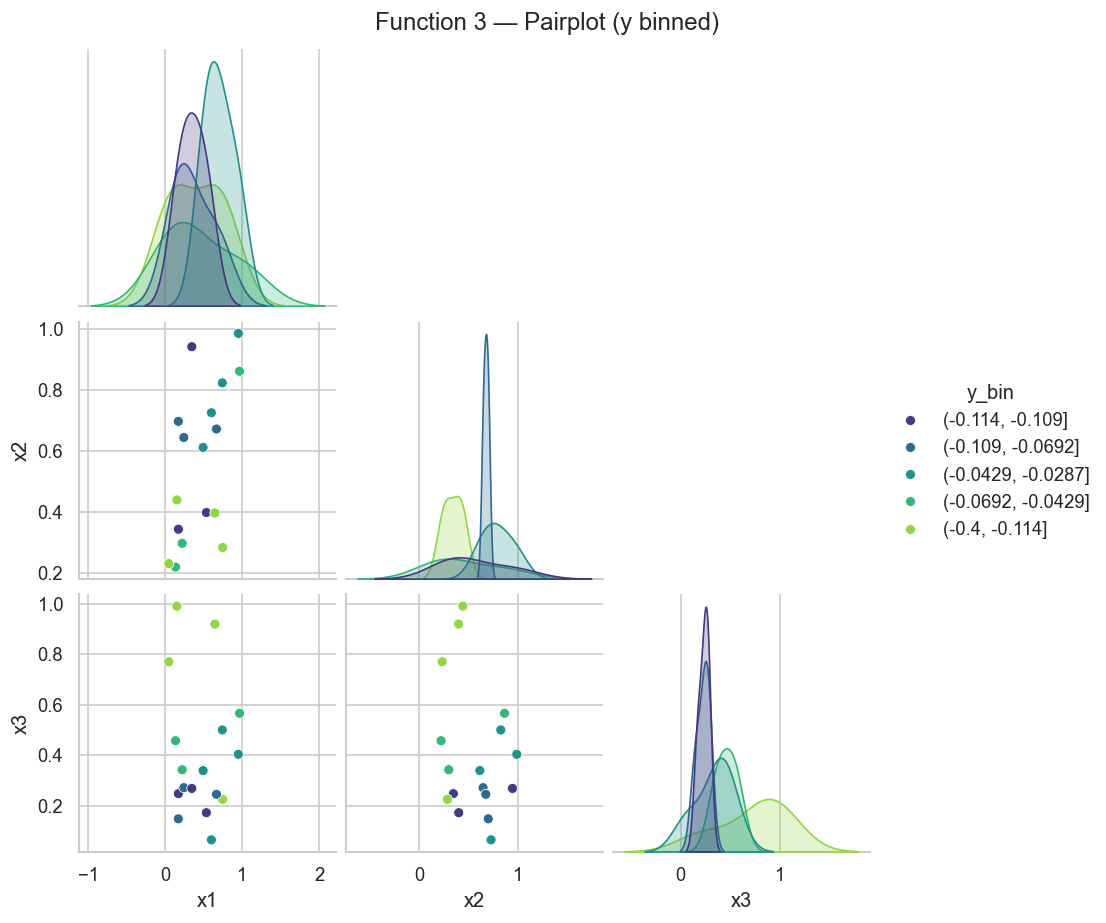

In [4]:
# --- 1. Carga ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, dtype=float)
y = np.asarray(y, dtype=float)

print(f"Shape X: {X.shape}, Shape y: {y.shape}")
print(f"y stats: min={y.min():.4f}  max={y.max():.4f}  mean={y.mean():.4f}  std={y.std():.4f}")
# === Week 1 : input -> , output ->     np.float64(-0.04185694811542118),
w1_input = np.array([0.94995968,0.98491081,0.40447853], dtype=float) 
w1_output = float(-0.04185694811542118)  # 

w2_input = np.array([0.741774, 0.823083, 0.500825], dtype=float) 
w2_output = float(-0.028695780761497047)  # 

X_prev, y_prev = X.copy(), y.copy()  # para colorear y anclar TR

# Actualizamos el dataset
X = np.vstack([X, w1_input, w2_input])
y = np.append(y, [w1_output, w2_output])

print(f"Week 1 added: x={w1_input}, y={w1_output}")
print(f"Week 2 added: x={w2_input}, y={w2_output}")
print(f"Updated shapes: X={X.shape}, y={y.shape}")

# Dispersión por pares (pairplot) coloreado por y (discretizado en quantiles)
df = pd.DataFrame(X, columns=["x1","x2","x3"])
# discretizamos y a bins para hue categórico
q = pd.qcut(pd.Series(y), q=min(6, max(2, len(y)//3)), duplicates="drop")
df["y_bin"] = q.astype(str)
sns.pairplot(df, hue="y_bin", corner=True, diag_kind="kde", palette="viridis")
plt.suptitle("Function 3 — Pairplot (y binned)", y=1.02)
plt.show()

# 3D scatter (si no tienes plotly, nos quedamos con pairplot)
try:
    import plotly.express as px
    fig = px.scatter_3d(x=X[:,0], y=X[:,1], z=X[:,2], color=y, color_continuous_scale="viridis",
                        title="Function 3 — 3D scatter coloured by y",
                        labels={"x":"x1","y":"x2","z":"x3","color":"y"})
    fig.add_scatter3d(x=[w1_input[0]], y=[w1_input[1]], z=[w1_input[2]],
                        mode="markers", marker=dict(size=6, color="red", symbol="diamond"),
                        name=f"Week 1 (y={w1_output:.4f})")
    fig.add_scatter3d(x=[w2_input[0]], y=[w2_input[1]], z=[w2_input[2]],
                        mode="markers", marker=dict(size=6, color="blue", symbol="diamond"),
                        name=f"Week 2 (y={w2_output:.4f})")
    
    fig.show()
except Exception as e:
    print("[INFO] plotly no disponible, continúa con pairplot.")

In [6]:
# --- 2. GP con ARD + ruido explícito ---
# Nota: y es negativa (efectos adversos transformados). Usamos normalize_y=True.
# semana dos: bounds: 1e-6, 5.0
#semana 3, vamos a ajustar los bounds:0.05, 2.0
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=[0.3, 0.3, 0.3], nu=2.5, length_scale_bounds=(0.05, 2.0))
    + WhiteKernel(noise_level=0.03, noise_level_bounds=(1e-4, 0.5))
)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=20, random_state=0)
gp.fit(X, y)
print("Kernel ajustado:", gp.kernel_)

# Guardamos mejor punto observado (para slices)
best_idx = np.argmax(y)
x_best, y_best = X[best_idx], y[best_idx]
print("Mejor observado:", x_best, "  y_best:", y_best)

Kernel ajustado: 1.17**2 * Matern(length_scale=[2, 2, 0.0763], nu=2.5) + WhiteKernel(noise_level=0.0107)
Mejor observado: [0.741774 0.823083 0.500825]   y_best: -0.028695780761497047


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.



In [7]:
# --- 3. Candidatos dentro del rango observado + acolchado ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)
print("Bounds usados:\n lb:", lb, "\n ub:", ub)

# Generación de candidatos uniformes (puedes aumentar N si tu máquina lo aguanta)
N = 40000
rng = np.random.default_rng(42)
Cands = rng.random((N, 3)) * (ub - lb) + lb

# Predicción GP y EI∫
from scipy.stats import norm

# --- Predicción GP ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- EI (ruido medio) ---
y_ref = y.max()  # usa el mejor actual (si añadiste W1) o el mejor inicial
xi = 0.02
Z = (mu - y_ref - xi) / sigma
ei = (mu - y_ref - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-borde ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)

# --- Trust Region (opcional, recomendada): caja alrededor del mejor inicial (no W1) ---
anchor = X_prev[np.argmax(y_prev)]
L = 0.50  # 50% del rango observado
lb_tr = np.clip(anchor - 0.5*L*(ub - lb), 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5*L*(ub - lb), 0.0, 1.0)
mask_tr = np.all((Cands >= lb_tr) & (Cands <= ub_tr), axis=1)

mask_final = mask_edges & mask_tr
ei_masked = np.where(mask_final, ei, -np.inf)

# --- Anti-duplicado / anti-vecindad (L_inf) ---
def too_close(x, X, tol=0.02):
    return np.any(np.max(np.abs(X - x), axis=1) < tol)

order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close(cand, X, tol=0.02):
        x_next = cand
        break

# Fallback: relaja TR si no hay candidato válido
if x_next is None:
    ei_relax = np.where(mask_edges, ei, -np.inf)
    for idx in np.argsort(-ei_relax):
        cand = Cands[idx]
        if not too_close(cand, X, tol=0.02):
            x_next = cand
            break

print("Suggested next point:", x_next) #Suggested next point: [0.74177373 0.82308265 0.50082525]

print("Submission format:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f} - {x_next[2]:.6f}")

Bounds usados:
 lb: [0.         0.14341788 0.        ] 
 ub: [1. 1. 1.]
Suggested next point: [0.25068641 0.41579443 0.53579296]
Submission format:
0.250686 - 0.415794 - 0.535793


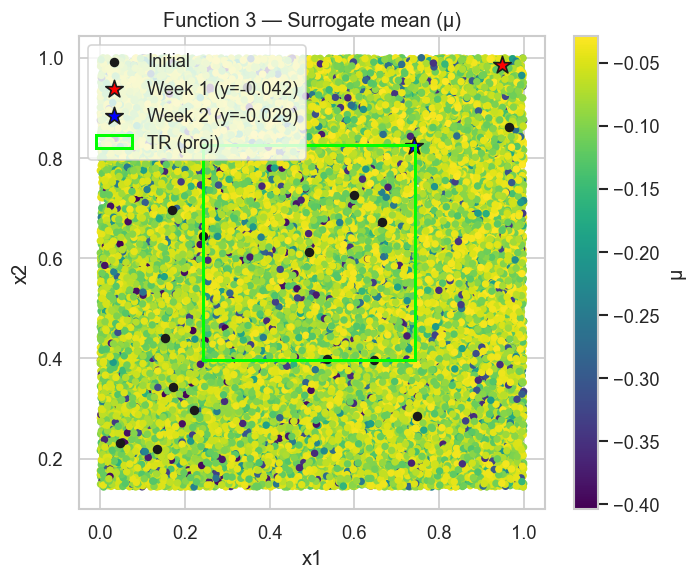

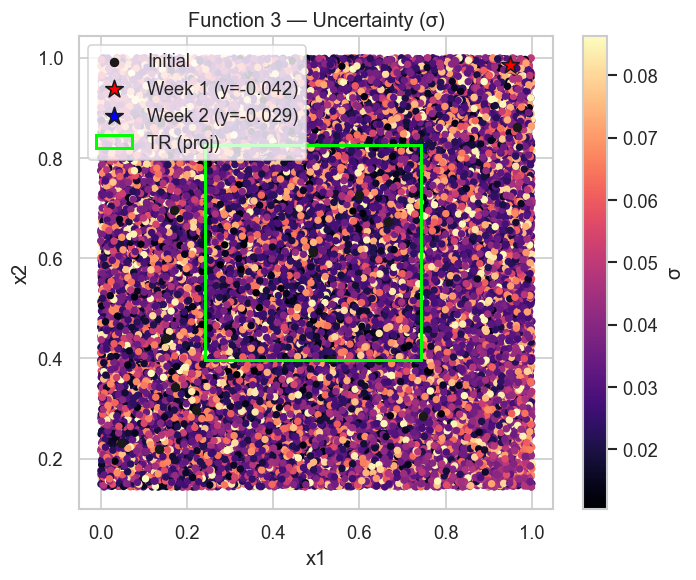

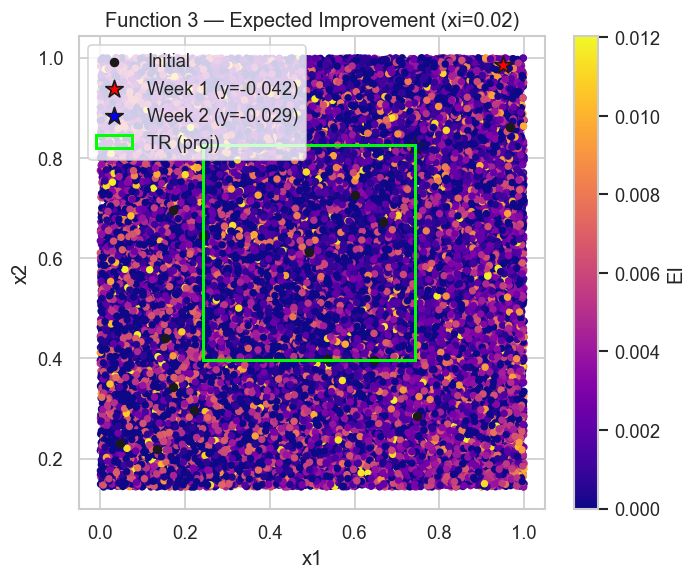

In [8]:
# Elegimos un corte por x3 cercano al ancla para visualizar EI en (x1,x2)
# (solo visual: tomamos el mu/σ/EI ya computado sobre Cands)
import matplotlib.pyplot as plt

def plot_heat_from_cands(C, values, title, cmap, label):
    # proyección 2D: usamos grid por ordenación; si no es rectangular, usamos scatter
    plt.figure(figsize=(6,5))
    sc = plt.scatter(C[:,0], C[:,1], c=values, cmap=cmap, s=12)
    plt.colorbar(sc, label=label)
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title(title)
    # puntos iniciales
    plt.scatter(X_prev[:,0], X_prev[:,1], c="k", s=22, label="Initial")
    # marca W1 si existe
    plt.scatter(w1_input[0], w1_input[1], c="red", s=120, marker="*", edgecolors="k", label=f"Week 1 (y={w1_output:.3f})")
    plt.scatter(w2_input[0], w2_input[1], c="blue", s=120, marker="*", edgecolors="k", label=f"Week 2 (y={w2_output:.3f})")
    # caja TR
    rect = plt.Rectangle(lb_tr[:2], *(ub_tr[:2]-lb_tr[:2]), fill=False, ec="lime", lw=1.8, label="TR (proj)")
    plt.gca().add_patch(rect)
    plt.legend(loc="best"); plt.tight_layout(); plt.show()

plot_heat_from_cands(Cands, mu, "Function 3 — Surrogate mean (μ)", "viridis", "μ")
plot_heat_from_cands(Cands, sigma, "Function 3 — Uncertainty (σ)", "magma", "σ")
plot_heat_from_cands(Cands, ei, f"Function 3 — Expected Improvement (xi={xi})", "plasma", "EI")

In [9]:
import numpy as np

cand = np.array([0.25068641, 0.41579443, 0.53579296])

def within_unit(c): 
    return np.all((c >= 0) & (c <= 1))

def too_close_Linf(c, X, tol=0.03):  # un poco más estricto en 3D
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

print("Within [0,1]? ", within_unit(cand))            # -> True esperado
print("Near-duplicate (L_inf < 0.03)? ", too_close_Linf(cand, X, 0.03))
print("Submission:\n" + " - ".join(f"{v:.6f}" for v in cand))

Within [0,1]?  True
Near-duplicate (L_inf < 0.03)?  False
Submission:
0.250686 - 0.415794 - 0.535793


	3.	Bitácora breve:
	•	Method: GP (Matern ARD) + EI (ξ=0.02), LHS + acolchado 10%.
	•	Decision: Punto no duplicado, algo alejado de W2 para refinar con diversidad.
	•	Next: Si mejora (y sube, menos negativo), bajar ξ a 0.015–0.01; si no, subir ξ a 0.03 y abrir un poco la TR.